In [66]:
import pandas as pd
import os,sys
import numpy as np

import matplotlib.pyplot as plt
import datetime

import sympy as sym
from sympy.solvers import solve
from sympy import Symbol
from sympy.parsing.sympy_parser import parse_expr

def eq_builder(a: np.array, var='s'):
    length = len(a)
    eq = ''
    for i, coef in enumerate(a):
#         print(i, coef)
        if i != 0 and str(coef)[0] != '-':
            eq += '+'
        if i != length-1:
            eq += str(coef) + '*{}**{}'.format(var, str(length-i-1))
            
        else:
            eq += str(coef)
        
    return eq

In [67]:
# dirname = '/Users/sangchoi/Downloads/intraday-market-data/'
# dir_etf = 'ETFs/'
# filename = 'iwm.us.txt'
# filename = 'TOS Kaggle data week ending 2020 03 21.csv'

# intraday dataset for popular ETFs
df = pd.read_csv('dataset.csv')
# The fastest falling date, 2020-03-16
df_filtered = df[np.logical_and(df.TimeStamp > '2020-03-16 11:00:00.0', df.TimeStamp < '2020-03-16 16:00:00.0')].reset_index()

In [68]:
print('reprocesing timestamp')
# convert timestamp to seconds
convert_to_datetime = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")

x = df_filtered.TimeStamp
y = df_filtered.SPY

x = x.apply(convert_to_datetime)
start = x[0]
normalize = lambda x: int((x - start).total_seconds())

x[0] = 0
x[1:] = x[1:].apply(normalize)
x = x.astype(float)
y = y.astype(float)


s = Symbol('x')

# possible inflection coordinates
x_inf = list()
y_inf = list()

reprocesing timestamp


starting analyzing...


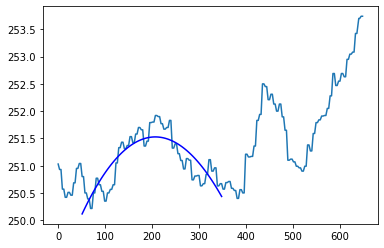

-1.68494279030512e-6 3.53701628711645e-8


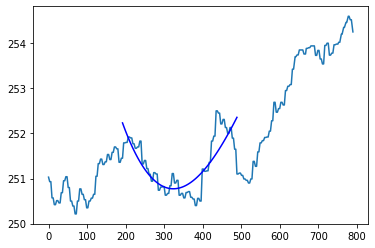

3.53701628711645e-8 -2.61691526424179e-7


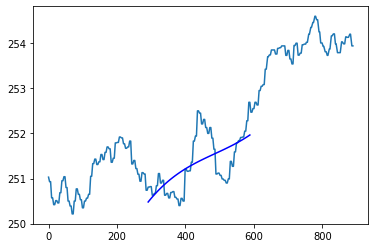

-2.61691526424179e-7 1.57305540496081e-7


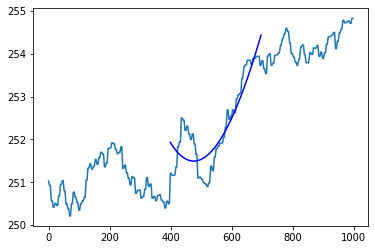

1.57305540496081e-7 -1.36663047812021e-7


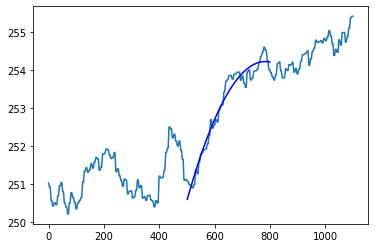

-1.36663047812021e-7 3.75497771899874e-9


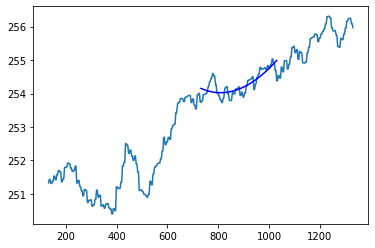

3.75497771899874e-9 -1.71834344687116e-8


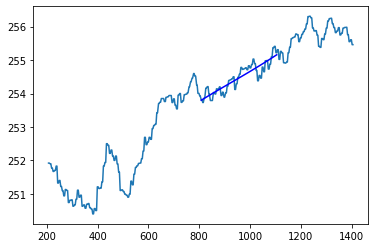

-1.71834344687116e-8 1.71333759570945e-8


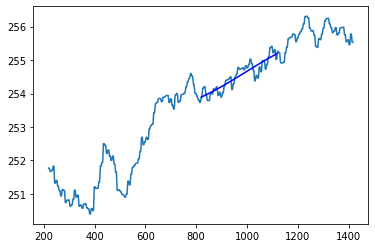

1.71333759570945e-8 -4.23595965898799e-8


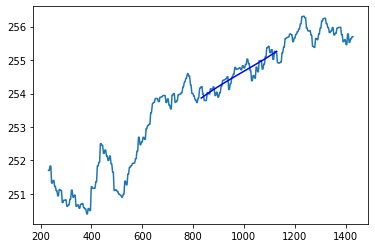

-4.23595965898799e-8 3.73216297285971e-8


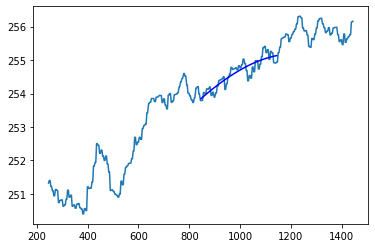

3.73216297285971e-8 -1.68760218030355e-8


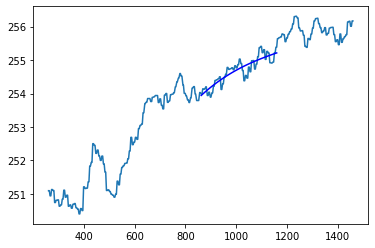

-1.68760218030355e-8 3.47836328084471e-8


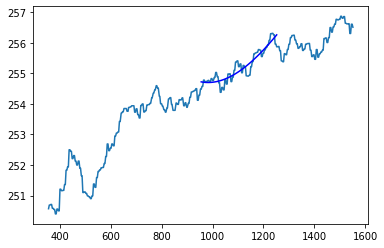

3.47836328084471e-8 -6.28620397626912e-8


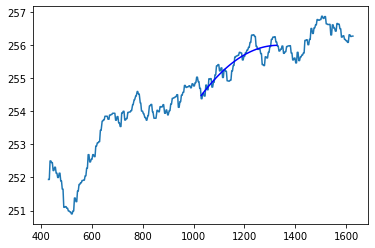

-6.28620397626912e-8 4.68718087675993e-9


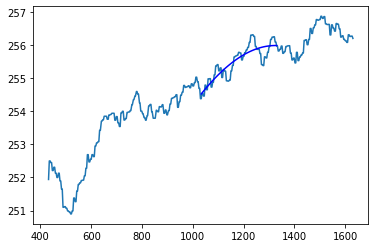

4.68718087675993e-9 -1.44587528765991e-8


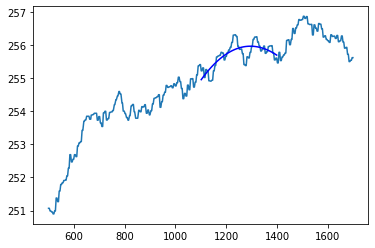

-1.44587528765991e-8 1.88258413273751e-8


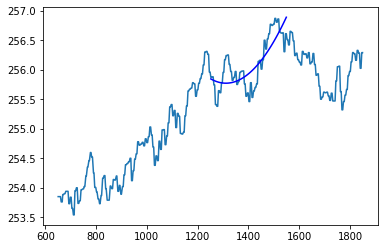

1.88258413273751e-8 -7.56162125808245e-9


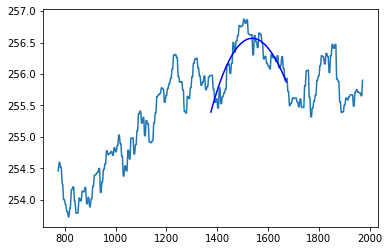

-7.56162125808245e-9 5.84421637002771e-8


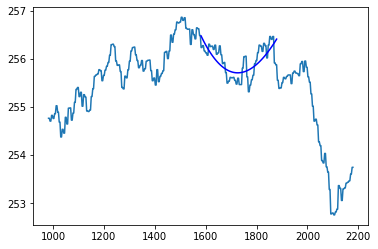

5.84421637002771e-8 -7.13684864328557e-8


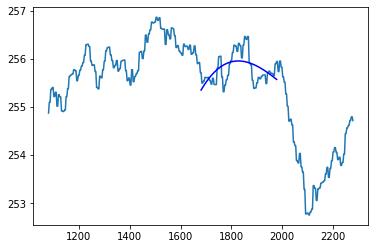

-7.13684864328557e-8 1.14188738687078e-7


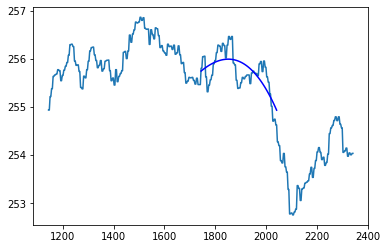

1.14188738687078e-7 -7.76141502093666e-8


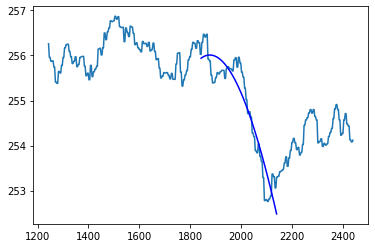

-7.76141502093666e-8 9.81456311958675e-8


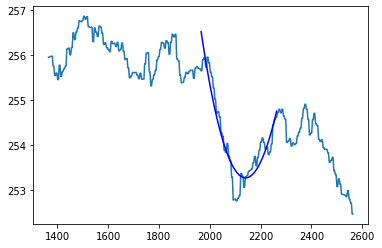

9.81456311958675e-8 -7.47700658689603e-8


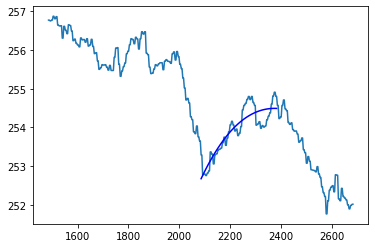

-7.47700658689603e-8 4.97414211695865e-8


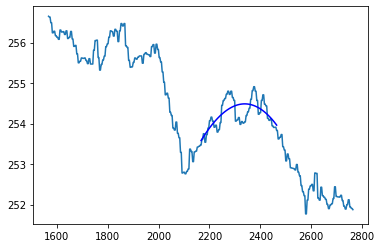

4.97414211695865e-8 -2.60463480169433e-8


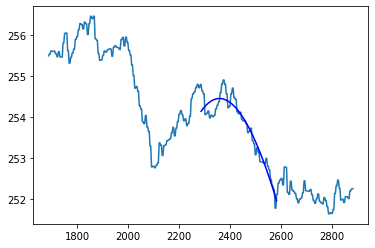

-2.60463480169433e-8 1.09654643554907e-7


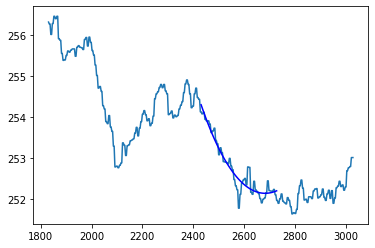

1.09654643554907e-7 -4.72270745485445e-8


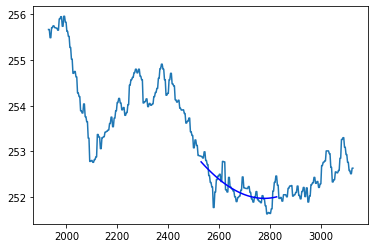

-4.72270745485445e-8 1.19468213767191e-8


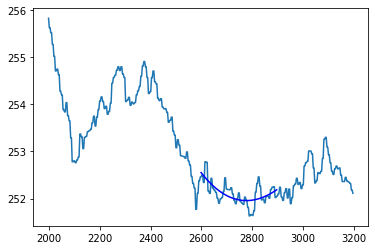

1.19468213767191e-8 -2.70837423682159e-8


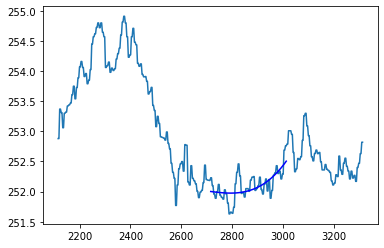

-2.70837423682159e-8 6.72869890574561e-8


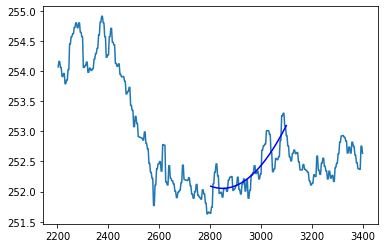

6.72869890574561e-8 -1.79822858284239e-10


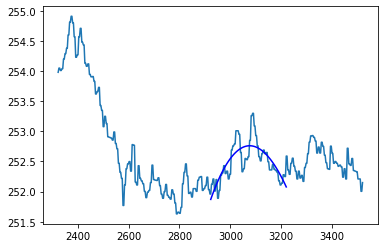

-1.79822858284239e-10 4.88356331083169e-8


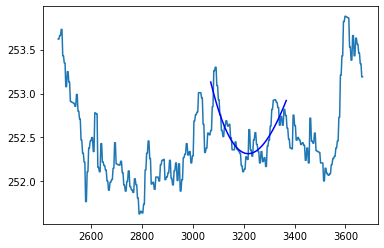

4.88356331083169e-8 -1.06689545859523e-7


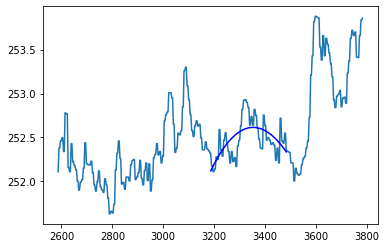

-1.06689545859523e-7 1.39894387894715e-8


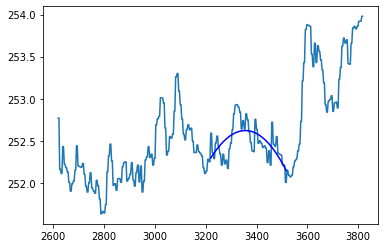

1.39894387894715e-8 -6.08129400040519e-9


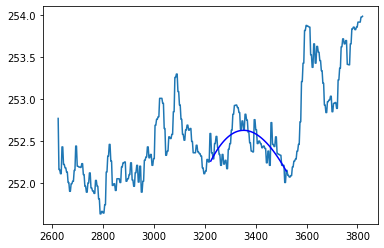

-6.08129400040519e-9 4.63805702145922e-8


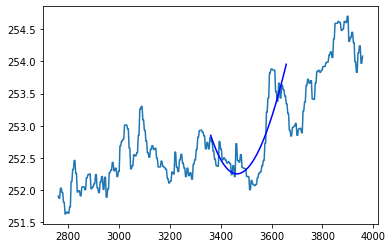

4.63805702145922e-8 -1.10577076926413e-7


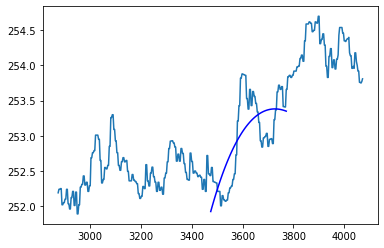

-1.10577076926413e-7 6.98709666455604e-8


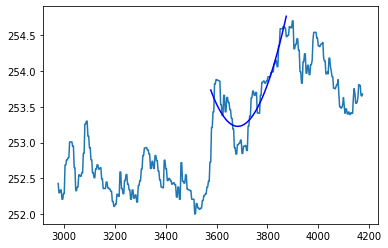

6.98709666455604e-8 -2.58922450655850e-8


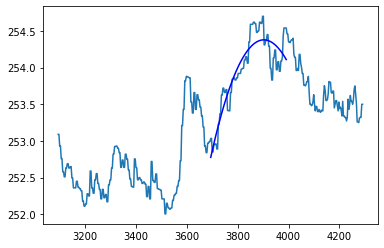

-2.58922450655850e-8 2.08333431455150e-8


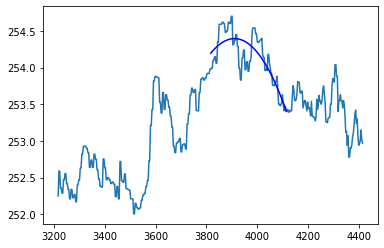

2.08333431455150e-8 -1.01869180364640e-8


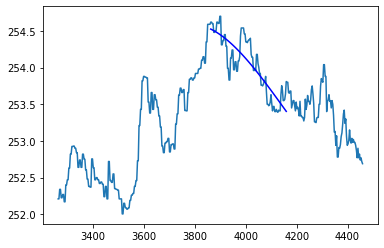

-1.01869180364640e-8 3.55122606978552e-8


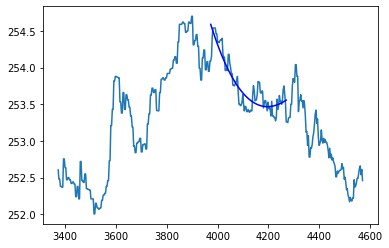

3.55122606978552e-8 -6.14896895267452e-8


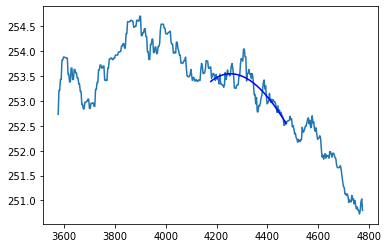

-6.14896895267452e-8 4.68508498080490e-8


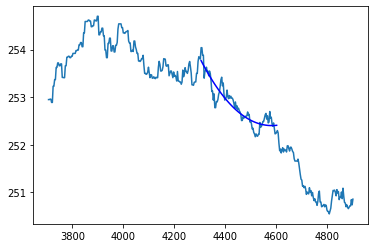

4.68508498080490e-8 -2.19454134671846e-8


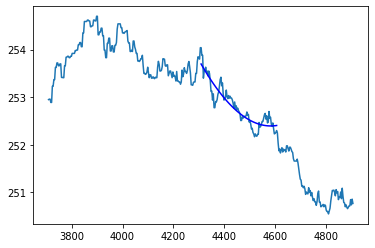

-2.19454134671846e-8 6.60275155346328e-9


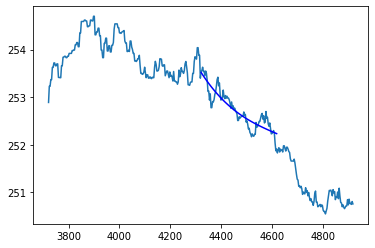

6.60275155346328e-9 -6.53502317473055e-8


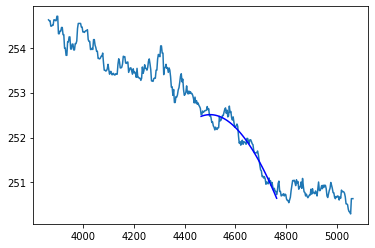

-6.53502317473055e-8 3.16705293050593e-8


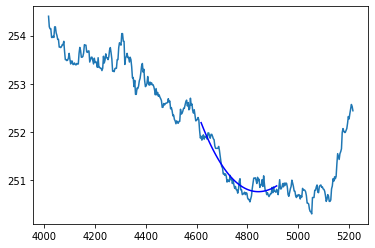

3.16705293050593e-8 -5.28943226118388e-8


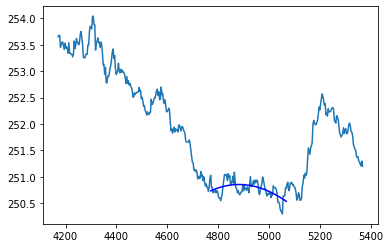

-5.28943226118388e-8 6.29264878051573e-9


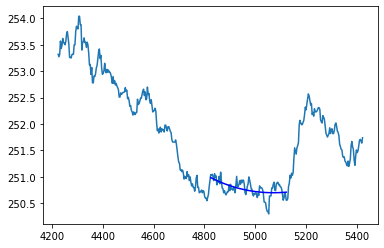

6.29264878051573e-9 -6.16883793731313e-9


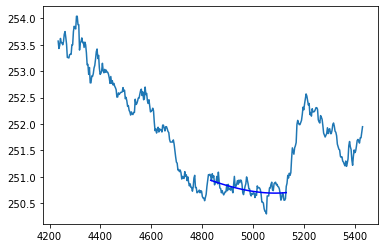

-6.16883793731313e-9 1.16623333603963e-8


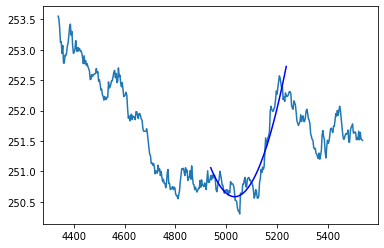

1.16623333603963e-8 -1.89250856402795e-8


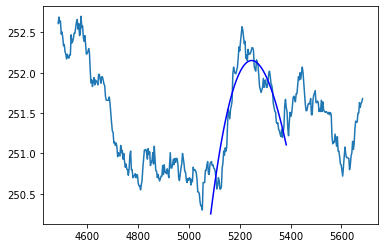

-1.89250856402795e-8 1.71171097656954e-7


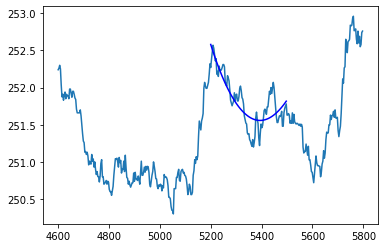

1.71171097656954e-7 -2.75914692816180e-8


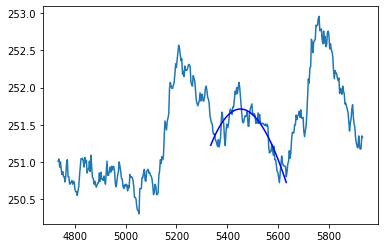

-2.75914692816180e-8 5.26955369837573e-8


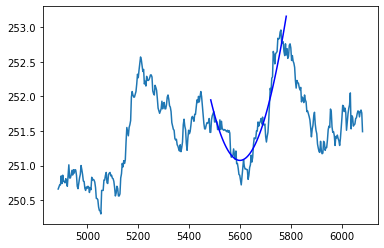

5.26955369837573e-8 -3.88886690387650e-8


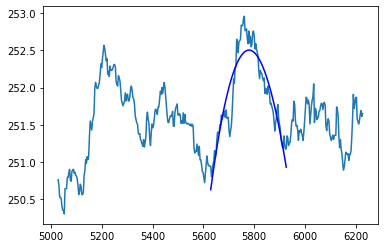

-3.88886690387650e-8 9.42786287194132e-8


In [ ]:
print('starting analyzing...')

# possible inflection coordinates
x_inf = list()
y_inf = list()

prev = None
window = 20 * 5 # 5 minutes moving window
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111)

# fig.show()
# fig.canvas.draw()

for i in range(len(x) - window):
    x_new = x[i:i+window]
    y_new = y[i:i+window]

    z = np.polyfit(x_new, y_new, 3)
    eq = eq_builder(z, 'x')
    sympy_exp = parse_expr(eq)

    # double derivative
#     d = sym.diff(sym.diff(eq, s), s)
    d = sympy_exp.diff(s).diff(s)
    result = solve(d,s)

#     print(i, result)
#     sympy_exp = parse_expr(eq)
    
    if len(result) == 1:
        l = d.evalf(subs={s: result[0]-0.5})
        r = d.evalf(subs={s: result[0]+0.5})
        if prev:
            if (prev >= 0 and r < 0) or (r >= 0 and prev < 0):
                x_inf += [list(x_new)[-1]]
                y_inf += [list(y_new)[-1]]

                f = np.poly1d(z)
                y_fit = f(x_new)
                
                inflection_point = sympy_exp.evalf(subs={s: result[0]})
                plt.plot(x[max(0,i-2*window):min(len(x),i+2*window)], y[max(0,i-2*window):min(len(x),i+2*window)], \
                         '-', x_new, y_fit, 'b-')

                plt.show()
                print(prev, r)
                prev = r
        else:
            prev = r

#                 print('concavity change detected.')
    else:
        print('unsolvable?', result)
        
print(x_inf)
print(y_inf)

In [ ]:
plt.figure(figsize=(30, 30))

plt.plot(x, y, '-', x_inf, y_inf, 'ro')
plt.show()